In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import export_graphviz, plot_tree
from graphviz import Source,Digraph
from sklearn.tree import DecisionTreeClassifier

In [2]:
class Generator():
    def __init__(self, n_stages=6,  n_ways=4, size=100):
        self.df = None        
        self.n_stages = n_stages
        self.n_ways = n_ways
        self.size = size
    
    def make_df(self):
        df_len = self.n_ways * self.size
        data = pd.DataFrame(np.arange(df_len), columns=['id'])
        data['stages'] = [0] * df_len
        ways = []
        while len(ways) != self.n_ways:
            way = [1] # start
            way_len = np.random.randint(2, self.n_stages)
            for _ in range(way_len):
                stage = np.random.randint(2, self.n_stages)
                way.append(stage)
            way.append(self.n_stages)
            way = pd.unique(way).tolist()
            if way not in ways and len(way) > 2:
                ways.append(way)                
        ways = np.repeat(ways, self.size)
        data['stages'] = ways            
        self.df = data
        return self    
    def make_features(self):
        data = self.df
        data = data.explode('stages')
        data['stages'] = data['stages'].astype(str)
        data['from'] = data.groupby(['id'])['stages'].shift(1)          
        edges = data.loc[:, ['from', "stages"]].drop_duplicates().dropna().values
        edges = [list(map(str, edge)) for edge in edges]                
        feature_cols = []
        i = 0
        for stage in data['stages'].unique():               
            transitions = list(filter(lambda x: stage in x[0], edges))
            if len(transitions) > 1:                
                stage_from = stage
                stages_to = [transition[1] for transition in transitions]

                train_mask = data['from'] == stage_from

                feat_name = 'X_{}'.format(i)
                for feat, stage_to in enumerate(stages_to):
                    mask = (data["stages"] == stage_to) & (data['from'] == stage_from)
                    data.loc[mask, feat_name] = (feat + 1) 
                    data.loc[mask, feat_name] += 1.1 * np.random.random(data.loc[mask, feat_name].shape[0]) - 0.55
                feature_cols.append(feat_name)
            i += 1
        data[data.columns[3:]] = data[data.columns[3:]].fillna(0)
        self.df = data
        return feature_cols, data        

In [18]:
class RuleFinder():
    def __init__(self, df, id_col, stage_col, feature_cols):
        self.df = df
        self.id_col = id_col
        self.stage_col = stage_col
        self.feature_cols = feature_cols
        self.graph = None
        
    def create_graph(self):
        stages = self.df[self.stage_col].unique()
        graph = Digraph(comment='Process', format = 'pdf')
        for stage in stages:
            graph.node(str(stage))
        self.df['from'] = self.df.groupby([self.id_col])[self.stage_col].shift(1)
        edges = self.df.loc[:, ['from', self.stage_col]].drop_duplicates().dropna().values
        edges = [list(map(str, edge)) for edge in edges]
        graph.edges(edges)
        self.graph = graph
        return graph
    
    def _save_dot(self, trees):
        for num, tree in trees.items():
            if tree != None:
                export_graphviz(trees[num], out_file='tree{}.dot'.format(num),
                    feature_names=self.feature_cols,node_ids=True)
    
    def _make_features(self):
        feature_cols = []
        i = 0
        for stage in self.df[self.stage_col].unique():
            transitions_str = list(filter(lambda x: '\t{} -> '.format(stage) in x, self.graph.body))
            if len(transitions_str) > 1:
                feature_cols.append('X_{}'.format(i))
                self.df['X_{}'.format(i)] = np.zeros(shape=self.df.shape[0])
                
                transitions = list(map(lambda x: x.strip().split(" -> "), transitions_str))

                stage_from = stage
                stages_to = [transition[1] for transition in transitions]

                train_mask = self.df['from'] == stage_from

                for feat, stage_to in enumerate(stages_to):
                    mask = (self.df[self.stage_col] == stage_to) & (self.df['from'] == stage_from)
                    self.df.loc[mask, 'X_{}'.format(i)] = feat + 1
                    self.df.loc[mask, 'X_{}'.format(i)] += 1.5*np.random.random(self.df.loc[mask, 'X_{}'.format(i)].shape[0]) -0.75
                i += 1
        self.feature_cols = feature_cols
        return self.df
    
    def compute_trees(self,min_impurity_decrease = 0.0015):
        trees = {}
        for stage in self.df[self.stage_col].unique():
            transitions_str = list(filter(lambda x: '\t{} -> '.format(stage) in x, self.graph.body))
            if len(transitions_str) > 1:
                transitions = list(map(lambda x: x.strip().split(" -> "), transitions_str))

                stage_from = stage
                stages_to = [transition[1] for transition in transitions]

                train_mask = self.df['from'] == stage_from

                for stage_to in stages_to:
                    mask = (self.df[self.stage_col] == stage_to) & (self.df['from'] == stage_from)
                    self.df.loc[mask, '_target_'] = stage_to

                X = self.df.loc[train_mask, self.feature_cols].values
                y = self.df.loc[train_mask, '_target_']
                
                min_class_ratio = 0.3 * np.min(y.value_counts()) / y.shape[0]
                tree = DecisionTreeClassifier(min_samples_leaf=min_class_ratio, min_impurity_split=0.2, min_impurity_decrease=min_impurity_decrease)
                tree.fit(X, y)
                
                trees[stage] = tree
            else:
                trees[stage] = None
        self.df.drop('_target_', inplace=True, axis=1)
        
        self._save_dot(trees)
        return trees
    

In [28]:
gen = Generator(n_stages=5, n_ways=10).make_df()
feature_cols, data = gen.make_features()

In [36]:
rule_finder = RuleFinder(data, 'id', 'stages', feature_cols)
graph = rule_finder.create_graph()
trees = rule_finder.compute_trees()

D:\Anaconda3\envs\Tensor\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
D:\Anaconda3\envs\Tensor\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
D:\Anaconda3\envs\Tensor\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
D:\Anaconda3\envs\Tensor\lib\site-packages\sklearn\tree\tree.py:297: DeprecationWarning: The m

In [31]:
trees

{'1': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0015, min_impurity_split=0.2,
                        min_samples_leaf=0.09, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 '4': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0015, min_impurity_split=0.2,
                        min_samples_leaf=0.04285714285714286,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        presort=False, random_state=None, splitter='best'),
 '3': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=N

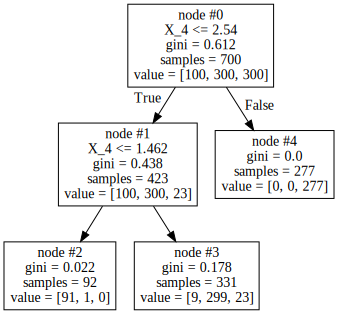

In [35]:
file = open('tree{}.dot'.format('2'), 'r')
text=file.read()
Source(text)

In [30]:
graph.view()

'Digraph.gv.pdf'